<a href="https://colab.research.google.com/github/moalsayed95/xgboost_time_series_prediction/blob/main/solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# World Data League 2022

## 🎯 Challenge
*Air Quality Prediction in Busy Streets*


## 👥 Authors
* Alexandra Alexandru
* Luiza Corpaci
* Bianca Dragomir
* Mohamad Al Sayed
* Alexander Schiel


## 💻 Development
Start coding here! 🐱‍🏍

Create the necessary subsections (e.g. EDA, different experiments, etc..) and markdown cells to include descriptions of your work where you see fit. Comment your code. 

All new subsections must start with three hash characters.

Pro-tip 1: Don't forget to make the jury's life easier. Remove any unnecessary prints before submitting the work. Hide any long output cells (from training a model for example). For each subsection, have a quick introduction (justifying what you are about to do) and conclusion (results you got from what you did). 

Pro-tip 2: Have many similiar graphs which all tell the same story? Add them to the appendix and show only a couple of examples, with the mention that all the others are in the appendix.

In [ ]:
!pip install xgboost

### Data Exploration


For the data exploration part, we're dealing with:
- reading the data
- properly formatting it
- solving missing data issues
- validations. 

We also have various visualizations used to get better insights into the data.



#### Imports

In [ ]:
import pandas as pd
import numpy as np
from functools import reduce
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings
from xgboost import XGBRegressor

warnings.simplefilter('ignore')

%matplotlib inline

# Set major seaborn asthetics
sns.set("notebook", style='ticks', font_scale=1.0)

# Increase the quality of inline plots
mpl.rcParams['figure.dpi']= 120

#### Reading data

For the current task, we chose to use the following datasets:
- [the provided air quality provided](https://wdl-data.fra1.digitaloceanspaces.com/unstudio/stadhouderskade_air_quality_2014_to_2022.csv) 
  - We used hourly measurements of pm10, pm25, fn, c8h10, c7h8, c6h6, no and no2
- [weather data](https://drive.google.com/file/d/1lVpdBYPNH2MVgZcYb8ZtQCBNbiqvAwFz/view?usp=sharing)
  - We used hourly measurements of temperature, visibility, human perception of temperature, cloudiness
- [lockdown periods](https://drive.google.com/file/d/1VO84JX4MofQleQ-omigkKLxOVmQuQSn-/view?usp=sharing)
  - Daily values for the type of lockdown in place

In [ ]:
# read data
url = 'https://wdl-data.fra1.digitaloceanspaces.com/unstudio/stadhouderskade_air_quality_2014_to_2022.csv'
df_main = pd.read_csv(url)

# df_lockdown = pd.read_csv('/content/drive/MyDrive/personal/wdl/lockdown.csv', names=['Date', 'Lockdown'])
# df_weather = pd.read_csv('/content/drive/MyDrive/personal/wdl/weather.csv')


from google.colab import drive
drive.mount("/content/gdrive")
df_lockdown = pd.read_csv('/content/gdrive/MyDrive/WDL/data/lockdown_data.csv', names=['Date', 'Lockdown'])
df_weather = pd.read_csv('/content/gdrive/MyDrive/WDL/data/weather_data.csv')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#### Cleaning Data - Weather data

We have 28 features in the weather data and selected the temperature, visibility, human perception of temperature and the cloudiness.

In [ ]:
print("Initial number of features: {}".format(len(df_weather.columns)))
# df_weather = df_weather[['dt_iso', 'temp', 'visibility', 'feels_like', 'weather_description', 'clouds_all', 'weather_main']]
df_weather = df_weather[['dt_iso', 'temp', 'visibility', 'feels_like', 'clouds_all']]

Initial number of features: 28


Correct date format

In [ ]:
df_weather['dt_iso'] = df_weather['dt_iso'].apply(lambda x: x[:25])
df_weather['dt_iso'] = df_weather['dt_iso'].apply(lambda x: x[0:18] + x[20:])
df_weather['dt_iso'] = df_weather['dt_iso'].apply(lambda x: x[0:21] + ':' + x[21:])

df_weather['dt_iso'] = pd.to_datetime(df_weather['dt_iso'])


# create a time filter for weather data
filt = (df_weather['dt_iso'] >= pd.Timestamp('2020-01-01', tz='utc')) & (df_weather['dt_iso'] < pd.Timestamp('2021-01-01', tz='utc'))
df_weather = df_weather.loc[filt]


,dt_iso,temp,visibility,feels_like,clouds_all
54972,2020-01-01 00:00:00+00:00,3.27,510.0,3.27,75
54973,2020-01-01 00:00:00+00:00,3.27,510.0,3.27,75
54974,2020-01-01 01:00:00+00:00,2.85,530.0,2.85,90
54975,2020-01-01 02:00:00+00:00,2.47,280.0,1.31,90
54976,2020-01-01 03:00:00+00:00,2.10,610.0,0.24,90
...,...,...,...,...,...
64443,2020-12-31 20:00:00+00:00,0.99,3180.0,0.99,1
64444,2020-12-31 21:00:00+00:00,1.05,2730.0,1.05,20
64445,2020-12-31 22:00:00+00:00,1.28,2260.0,-0.96,40
64446,2020-12-31 22:00:00+00:00,1.28,2260.0,-0.96,40


Fill missing data

In [ ]:
# fill the missing values with previous value
df_weather.fillna(method='ffill', inplace=True)

Looking at a the following results, we can get some insights into the weather data.

We see that the mean **temperature** over the analysised period is 11.89\*C, with a minimum of -0.93\*C and a maximum of 33\*C.

As for the **visibility**, we have an average of 8.9km, with a minimum of 40m and a maximum of 10km.

The **human perception of temperature** has lower average (11.13\*C) and minimum (-3.34\*C) values and a higher maximum value, compared to the measured temperature (35.28\*C).

The **clouds** measurement shows an average at 61.60%, going as low as 0% and as high as 90%.

In [ ]:
df_weather.describe()

,temp,visibility,feels_like,clouds_all
count,9476.000000,9476.000000,9476.000000,9476.000000
mean,11.894834,8973.290207,11.138739,61.602786
std,5.884377,2389.283374,6.433444,35.466660
min,-0.930000,40.000000,-3.340000,0.000000
25%,7.430000,10000.000000,6.060000,40.000000
50%,11.090000,10000.000000,10.405000,90.000000
75%,16.022500,10000.000000,15.770000,90.000000
max,33.140000,10000.000000,35.280000,90.000000


#### Cleaning Data - Air Quality data

Dropping duplicate values & dropping the 'id' column.

In [ ]:
df_main.drop_duplicates(keep=False,inplace=True)

# drop id since time stamps can be the unique identifier
df_main = df_main.drop(columns='id')

Correct date format

In [ ]:
# convert the time to datetime format
df_main['timestamp_measured'] = pd.to_datetime(df_main['timestamp_measured'])

# check the time range (Timedelta)
df_main['timestamp_measured'].max() - df_main['timestamp_measured'].min()
df_all_years = df_main.copy()
# create a time filter for main data (8 pollutants)
filt = (df_main['timestamp_measured'] >= pd.Timestamp('2020-01-01', tz='utc')) & (df_main['timestamp_measured'] < pd.Timestamp('2021-01-01', tz='utc'))
# filt = (df_main['timestamp_measured'] < pd.Timestamp('2021-01-01', tz='utc'))
df_main = df_main.loc[filt]


#### Formatting the air quality dataframe
Create a dictionary of dataframes for each element in the main dataframe.

In [ ]:

df_dict = {
    'pm25': df_main.query("component_id == 'PM25'"),
    'pm10': df_main.query("component_id == 'PM10'"),
    'fn': df_main.query("component_id == 'FN'"),
    'c8h10': df_main.query("component_id == 'C8H10'"),
    'c7h8': df_main.query("component_id == 'C7H8'"),
    'c6h6': df_main.query("component_id == 'C6H6'"),
    'no2': df_main.query("component_id == 'NO2'"),
    'no': df_main.query("component_id == 'NO'"),
}

Take timestamp and value for each feature and rename the columns according to pollutant name.

In [ ]:

df_pm25 = df_dict['pm25'][['timestamp_measured', 'value']]
df_pm10 = df_dict['pm10'][['timestamp_measured', 'value']]
df_fn = df_dict['fn'][['timestamp_measured', 'value']]
df_c8h10 = df_dict['c8h10'][['timestamp_measured', 'value']]
df_c7h8 = df_dict['c7h8'][['timestamp_measured', 'value']]
df_c6h6 = df_dict['c6h6'][['timestamp_measured', 'value']]
df_no2 = df_dict['no2'][['timestamp_measured', 'value']]
df_no = df_dict['no'][['timestamp_measured', 'value']]

df_pm25.rename(columns={'value':'pm25'}, inplace=True)
df_pm10.rename(columns={'value':'pm10'}, inplace=True)
df_fn.rename(columns={'value':'fn'}, inplace=True)
df_c8h10.rename(columns={'value':'c8h10'}, inplace=True)
df_c7h8.rename(columns={'value':'c7h8'}, inplace=True)
df_c6h6.rename(columns={'value':'c6h6'}, inplace=True)
df_no2.rename(columns={'value':'no2'}, inplace=True)
df_no.rename(columns={'value':'no'}, inplace=True)

We want to have records of pollutants every 6 hours, for this reason we use resampling.

We also consider taking the mean value to fill the gaps.

In [ ]:
def resample_df(df): 
  df_sampled = df.reset_index().set_index('timestamp_measured').resample('6H').mean()
  df_sampled = df_sampled.reset_index()
  df_sampled.drop('index', inplace=True, axis=1)
  return df_sampled

df_pm25 = resample_df(df_pm25)
df_pm10 = resample_df(df_pm10)

df_fn = resample_df(df_fn)
df_c8h10 = resample_df(df_c8h10)

df_c7h8 = resample_df(df_c7h8)
df_c6h6 = resample_df(df_c6h6)

df_no2 = resample_df(df_no2)
df_no = resample_df(df_no)

Fill the missing values with previous value.

In [ ]:

df_pm25.fillna(method='ffill', inplace=True)
df_pm10.fillna(method='ffill', inplace=True)
df_fn.fillna(method='ffill', inplace=True)
df_c8h10.fillna(method='ffill', inplace=True)
df_c7h8.fillna(method='ffill', inplace=True)
df_c6h6.fillna(method='ffill', inplace=True)
df_no2.fillna(method='ffill', inplace=True)
df_no.fillna(method='ffill', inplace=True)

Filter the outliers (negative values).

In [ ]:

filt = (df_pm10['pm10'] > 0)
df_pm10 = df_pm10.loc[filt]

filt = (df_pm25['pm25'] > 0)
df_pm25 = df_pm25.loc[filt]

filt = (df_fn['fn'] > 0)
df_fn = df_fn.loc[filt]

filt = (df_c8h10['c8h10'] > 0)
df_c8h10 = df_c8h10.loc[filt]

filt = (df_c7h8['c7h8'] > 0)
df_c7h8 = df_c7h8.loc[filt]

filt = (df_c6h6['c6h6'] > 0)
df_c6h6 = df_c6h6.loc[filt]

filt = (df_no2['no2'] > 0)
df_no2 = df_no2.loc[filt]

filt = (df_no['no'] > 0)
df_no = df_no.loc[filt]

Resample again.

In [ ]:

df_pm25 = resample_df(df_pm25)
df_pm10 = resample_df(df_pm10)

df_fn = resample_df(df_fn)
df_c8h10 = resample_df(df_c8h10)

df_c7h8 = resample_df(df_c7h8)
df_c6h6 = resample_df(df_c6h6)

df_no2 = resample_df(df_no2)
df_no = resample_df(df_no)

Sanity check on the dataframe sizes.

In [ ]:
assert len(df_pm25) == len(df_pm10) == len(df_fn) == len(df_c7h8) == len(df_c6h6) == len(df_no2) == len(df_no) == len(df_c8h10)

Concatenate all pollutants dataframes.

In [ ]:
df_sampled_6h = pd.concat([df_pm25, df_pm10['pm10'], df_fn['fn'], df_c8h10['c8h10'], df_c7h8['c7h8'], df_c6h6['c6h6'], df_no2['no2'], df_no['no']], axis=1)
df_sampled_6h['day_of_week'] = df_sampled_6h.timestamp_measured.dt.weekday

We resample the weather data in the same way to match the main dataframe.

We also consider taking the mean value to fill the gaps.

In [ ]:
def resample_df_weather(df): 
  df_sampled = df.reset_index().set_index('dt_iso').resample('6H').mean()
  df_sampled = df_sampled.reset_index()
  df_sampled.drop('index', inplace=True, axis=1)
  return df_sampled

df_weather = resample_df_weather(df_weather)

df_combined = pd.concat([df_sampled_6h, df_weather], axis=1)

Drop the dt_iso column

In [ ]:
df_combined.drop(columns='dt_iso', inplace=True)

Check the final dataframe

In [ ]:
df_combined['aqi'] = (df_combined['pm10'] + df_combined['pm25'] + df_combined['fn'] + df_combined['c8h10'] + df_combined['c7h8'] + df_combined['c6h6'] + df_combined['no2'] + df_combined['no'])/8

In [ ]:
# # normalize features
# def normalize_features(df: pd.DataFrame, feature_list: list) -> pd.DataFrame:
#   for feature in feature_list:
#     df[feature] =(df[feature]-df[feature].mean())/df[feature].std()
#   return df

# # get feature statistics
# def describe_feature(df: pd.DataFrame, feature_list: list):
#   """descibes the numerical feature in dataset by printing:
#   mean, standard deviation, min and max values
#   """
#   for feature in feature_list:
#     print('statistics for '+ feature)
#     print('mean = ' + str(df[feature].describe()['mean']))
#     print('std = ' + str(df[feature].describe()['std']))
#     print('min = ' + str(df[feature].describe()['min']))
#     print('max = '  + str(df[feature].describe()['max']) + '\n')

# # select the features to normalize
# feature_list_to_normalize = ['pm10', 'pm25', 'fn', 'c8h10', 'c7h8', 'c6h6', 'no2', 'no']

# # apply normalization
# df_sampled_6h = normalize_features(df_sampled_6h, feature_list_to_normalize)

# # select features to describe
# feature_list_to_describe = ['pm10', 'pm25', 'fn', 'c8h10', 'c7h8', 'c6h6', 'no2', 'no']
# describe_feature(df_sampled_6h, feature_list_to_describe)

In [ ]:
df_combined['aqi_target'] = df_combined['aqi'].shift(-1)
df_combined.dropna(inplace=True)

Final form of the dataframe

In [ ]:
df_combined

,timestamp_measured,pm25,pm10,fn,c8h10,c7h8,c6h6,no2,no,day_of_week,temp,visibility,feels_like,clouds_all,aqi,aqi_target
0,2020-01-01 00:00:00+00:00,173.950000,190.766667,4.373333,0.213333,1.466667,1.146667,40.133333,27.933333,2,2.540000,521.428571,1.661429,85.714286,54.997917,20.318125
1,2020-01-01 06:00:00+00:00,56.000000,58.783333,2.310000,0.148333,1.086667,0.783333,29.433333,14.000000,2,0.905000,903.750000,-0.038750,90.000000,20.318125,16.811458
2,2020-01-01 12:00:00+00:00,34.866667,39.033333,1.721667,0.245000,1.810000,0.798333,30.250000,25.766667,2,1.805000,2108.333333,0.085000,90.000000,16.811458,17.055000
3,2020-01-01 18:00:00+00:00,37.750000,40.516667,1.795000,0.271667,2.148333,0.908333,33.433333,19.616667,2,2.526667,3230.000000,0.688333,90.000000,17.055000,13.323958
4,2020-01-02 00:00:00+00:00,28.616667,38.520000,1.266667,0.156667,0.915000,0.783333,27.200000,9.133333,3,2.085000,1422.500000,0.487500,90.000000,13.323958,12.638750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458,2020-12-30 12:00:00+00:00,4.350000,5.750000,0.721667,0.420000,1.836667,0.958333,29.766667,14.716667,2,5.831667,10000.000000,4.971667,81.666667,7.315000,8.324375
1459,2020-12-30 18:00:00+00:00,7.050000,9.016667,1.051667,0.620000,2.636667,1.153333,34.683333,10.383333,2,4.155714,10000.000000,3.044286,61.428571,8.324375,4.979792
1460,2020-12-31 00:00:00+00:00,5.833333,6.616667,0.366667,0.206667,0.808333,0.573333,22.133333,3.300000,3,2.935000,10000.000000,2.935000,87.500000,4.979792,11.067083
1461,2020-12-31 06:00:00+00:00,11.883333,13.983333,1.101667,0.466667,2.018333,1.116667,39.000000,18.966667,3,2.501667,7470.000000,2.501667,64.333333,11.067083,12.908125


### Training model

We used the XGBoost model for the training on the data, trying different cases of input features.
- considering air pollutants data
- considering weather data
- considering all features (air pollutants + weather data)


Selecting which data to use for the training of the model

In [ ]:
# if we want to consider all features in the data
# X = df_combined.iloc[:,:-2]
# y = df_combined.iloc[:,-1]

# if we want to exclude the pollutants from the data
y = df_combined.iloc[:,-1]
X = pd.concat([df_combined.iloc[:,0:1], df_combined.iloc[:,9:-2]], axis = 1) 

Splitting into train & test dataframes.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE

# Splitting
train_X, test_X, train_y, test_y = train_test_split(X, y,
                      test_size = 0.3, random_state = 123)
  

Generating model

In [ ]:
# Model Instantiation
model = XGBRegressor(objective ='reg:linear', n_estimators = 700, seed = 123)
  
# Fitting the model
model.fit(train_X.iloc[:,1:], train_y)
  
# Predict the model
pred = model.predict(test_X.iloc[:,1:])
  
# RMSE Computation
rmse = np.sqrt(MSE(test_y, pred))
print("RMSE : % f" %(rmse))

[11:25:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE :  3.791109


In [ ]:
assert len(pred) == len(test_y)

Getting the results

In [ ]:
df_result = pd.DataFrame(data=[])
df_result['timestamp_measured'] = test_X['timestamp_measured']
df_result['ground_truth'] = test_y
df_result['prediction'] = pred

df_result

,timestamp_measured,ground_truth,prediction
739,2020-07-03 18:00:00+00:00,4.660625,6.165549
18,2020-01-05 12:00:00+00:00,8.633750,11.518917
782,2020-07-14 12:00:00+00:00,4.404375,4.610023
230,2020-02-27 12:00:00+00:00,7.050833,8.991987
1312,2020-11-24 00:00:00+00:00,15.396875,8.785569
...,...,...,...
867,2020-08-04 18:00:00+00:00,5.802708,7.659227
1348,2020-12-03 00:00:00+00:00,15.437500,12.560930
725,2020-06-30 06:00:00+00:00,6.626042,7.266371
104,2020-01-27 00:00:00+00:00,12.330833,7.742292


Feature importance 
!!!!! TO DO - explained how the feature importance is computed

In [ ]:
# check the feature importance
print(model.feature_importances_)

[0.1673209  0.27567762 0.22459978 0.18259224 0.1498094 ]


## 🖼️ Visualisations
Copy here the most important visualizations (graphs, charts, maps, images, etc). You can refer to them in the Executive Summary.

Technical note: If not all the visualisations are visible, you can still include them as an image or link - in this case please upload them to your own repository.

In [ ]:
import matplotlib.pyplot as plt
import plotly.express as px
feature = 'aqi'


def plot_slider(x, y, title='', xlabel='Date', ylabel='Value', dpi=100, figsize=(16,5), color='blue'):
  fig=px.line(x=x, y=y, title=title)
  fig.update_xaxes(rangeslider_visible=True)
  fig.show()


def plot_df(df, date, value, title="", xlabel='Date', ylabel='Value', dpi=100, figsize=(16,5), color='blue'):
    plt.figure(figsize=figsize, dpi=dpi)
    plt.plot(date, value, color=color)
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()


In [ ]:
df = df_combined.copy()
df = df.rename(columns={'timestamp_measured':'Date'})
df.set_index('Date', inplace=True)

Plotting the AQI for the whole selected time period.

In [ ]:
plot_slider(df.index, df['aqi'], feature + ' value for 2020', ylabel=feature)

Plotting the boxplot for each month in the dataset in order to check the seasonal behaviour. We notice that January, September, November and December have the highest averages and also the highest maximums.

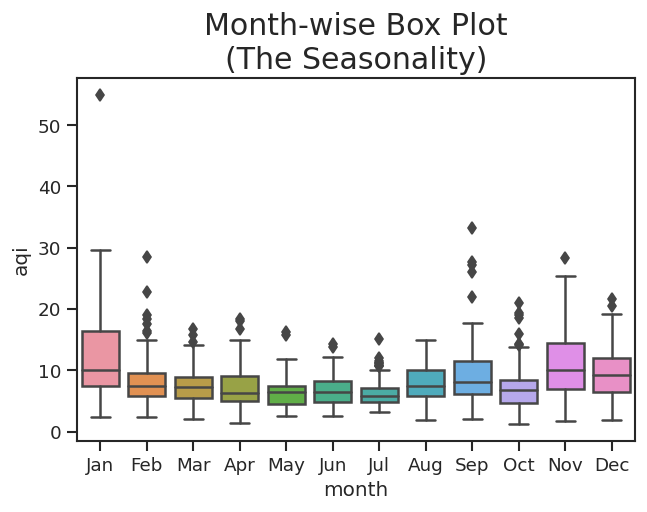

In [ ]:
# Prepare data
df['year'] = [d.year for d in df.index]
df['month'] = [d.strftime('%b') for d in df.index]

# Draw Plotx
# fig, axes = plt.plot(figsize=(20,7), dpi= 80)
# sns.boxplot(x='year', y=feature, data=df, ax=axes[0])
sns.boxplot(x='month', y=feature, data=df)

# Set Title
# axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
plt.title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

### Seasonal decomposition

**Seasonality** describes the periodicity of the time series.

The **trend** describes the tendency to increase/decrease or remain constant over time.

The **residual** shows the data that cannot be explained by the model.

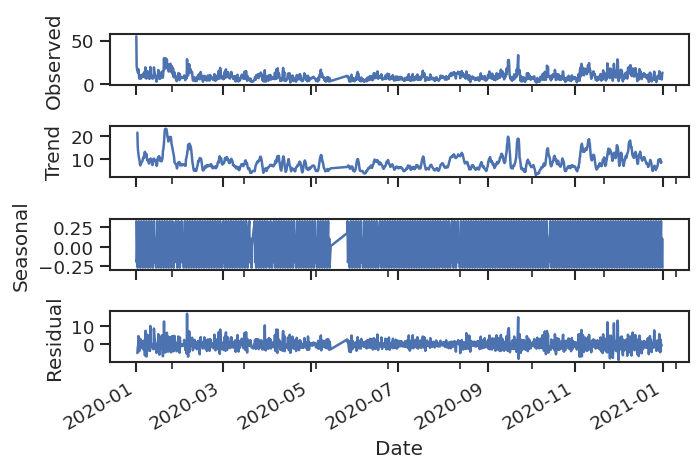

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose = seasonal_decompose(df[feature], model='additive', freq=7)
decompose.plot()
plt.show()

## Autocorrelation

Checking the autocorrelation for the selected feature on a **weekly** basis.

We're checking to see how similar the time series values are to other values within the time series itself.

The strength of the relationship is measured on a scale of -1 (100% negative correlation) to 1 (100% positive correlation.


We used weekly averages for the following plot and we see that the present is more similar to the recent past (0-15 weeks) and to the period from one year before (closer similarities in terms of weather, season, etc).

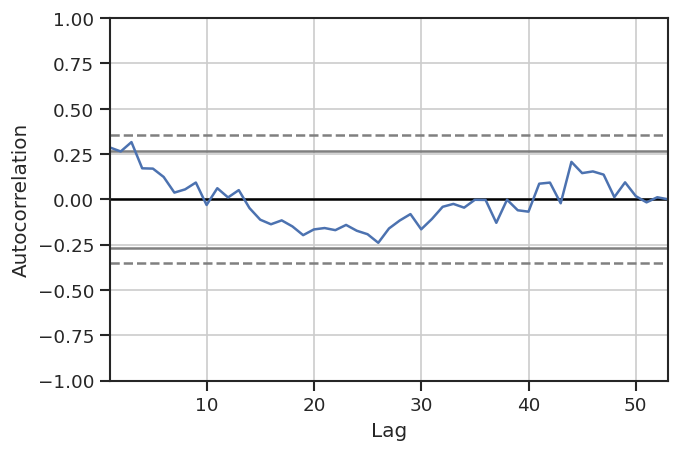

In [ ]:
from pandas.plotting import autocorrelation_plot

df_week = df.copy()

df_week = df_week.resample('W').mean()
df_week = df_week.interpolate(method='linear')
autocorrelation_plot(df_week[feature].tolist())

Checking the autocorrelation for the selected feature on a **monthly** basis.

In the case of the monthly basis, we notice a similar behavior (higher dependence on recent-past and far past, than on medium past), just with a lower resolution.

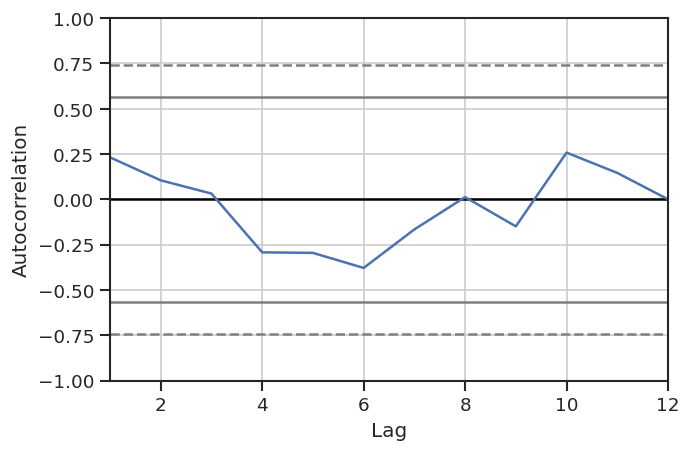

In [ ]:
from pandas.plotting import autocorrelation_plot

df_month = df.copy()

df_month = df_month.resample('M').mean()
df_month = df_month.interpolate(method='linear')
autocorrelation_plot(df_month[feature].tolist())

Sampling the air pollution dataframe to daily averages and aggregating the data with the lockdown periods.

In [ ]:
df_day = df.copy()
df_day.reset_index(inplace=True)
df_day = df_day.groupby(df_day['Date'].dt.to_period('D')).mean()
df_day.reset_index(inplace=True)
df_day['Date'] = df_day['Date'].astype('string')
df_day = df_day.rename(columns={"Date":"Date"})

df_day_lockdown = pd.merge(df_lockdown, df_day, on='Date', how='inner')

Setting up the function for plotting the air quality data on lockdown periods.

In [ ]:
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

def plot_lockdown_air(df_day_lockdown, features):

  df_day_plot = df_day_lockdown.copy()
  df_day_plot['Lockdown'] = df_day_plot['Lockdown'].astype(int).astype(str).map(lambda x: 'C'+x)

  ax = sns.lineplot(x="Date", y=features[0], data=df_day_plot)
  if len(features) > 1:
    for feature in features[1:]:
      sns.lineplot(x="Date", y=feature, data=df_day_plot, ax=ax)
  ax.set(title= 'Measurements per lockdown periods \n(0 - no lockdown, 1 - soft lockdown, 2 - hard lockdown)', xlabel='Date', ylabel='Measurement value')

  height = df_day_lockdown[features[0]].max()*0.90
  ax.text(35, height, "0", horizontalalignment='left', size='small', color='black',)
  ax.text(73, height, "1", horizontalalignment='left', size='small', color='black')
  ax.text(100, height, "2", horizontalalignment='left', size='small', color='black')
  ax.text(200, height, "1", horizontalalignment='left', size='small', color='black')
  ax.legend(features)

  ranges = df_day_plot.groupby('Lockdown')['Date'].agg(['min', 'max'])
  for i, row in ranges.iterrows():
      ax.axvspan(xmin=row['min'], xmax=row['max'], facecolor=i, alpha=0.3)

In the next plot we see the **lockdown** periods:
- 0: *no lockdown* (blue)
- 1: *soft lockdown* (orange)
- 2: *hard lockdown* (green)

Plotting the air quality index (aqi) over the year 2020, we notice that during the *hard lockdown* the aqi has decreased (lower pollution), compared to the begining of the *no lockdown*  and to the end of the *soft lockdown* periods of time.

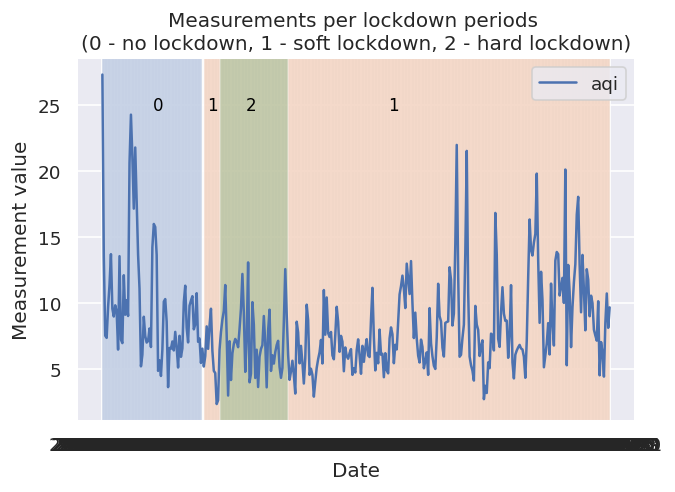

In [ ]:
plot_lockdown_air(df_day_lockdown, ['aqi'])

After looking at the previous plot, we came with the hypothesis that the lower number of cars might during the lockdown might have had an effect on the pollution levels.

In the next plot, we can see the C8H10, C7H8 and C6H6 measurements (main car pollutants) over the selected period and their values during the different lockdown types.

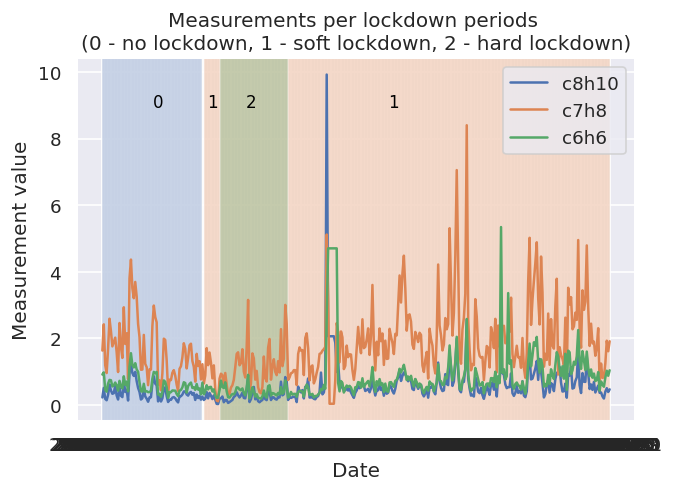

In [ ]:
plot_lockdown_air(df_day_lockdown, ['c8h10', 'c7h8', 'c6h6'])

Creating a filter for the result data

In [ ]:
# create a time filter to get a better view of results
start_time = '2020-01-01'
end_time = '2021-01-01'
filt = (df_result['timestamp_measured'] >= pd.Timestamp(start_time, tz='utc')) & (df_result['timestamp_measured'] < pd.Timestamp(end_time, tz='utc'))
df_result = df_result.loc[filt]

# set the date as index
df = df_combined.copy()
df = df.rename(columns={"timestamp_measured":"Date"})
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)

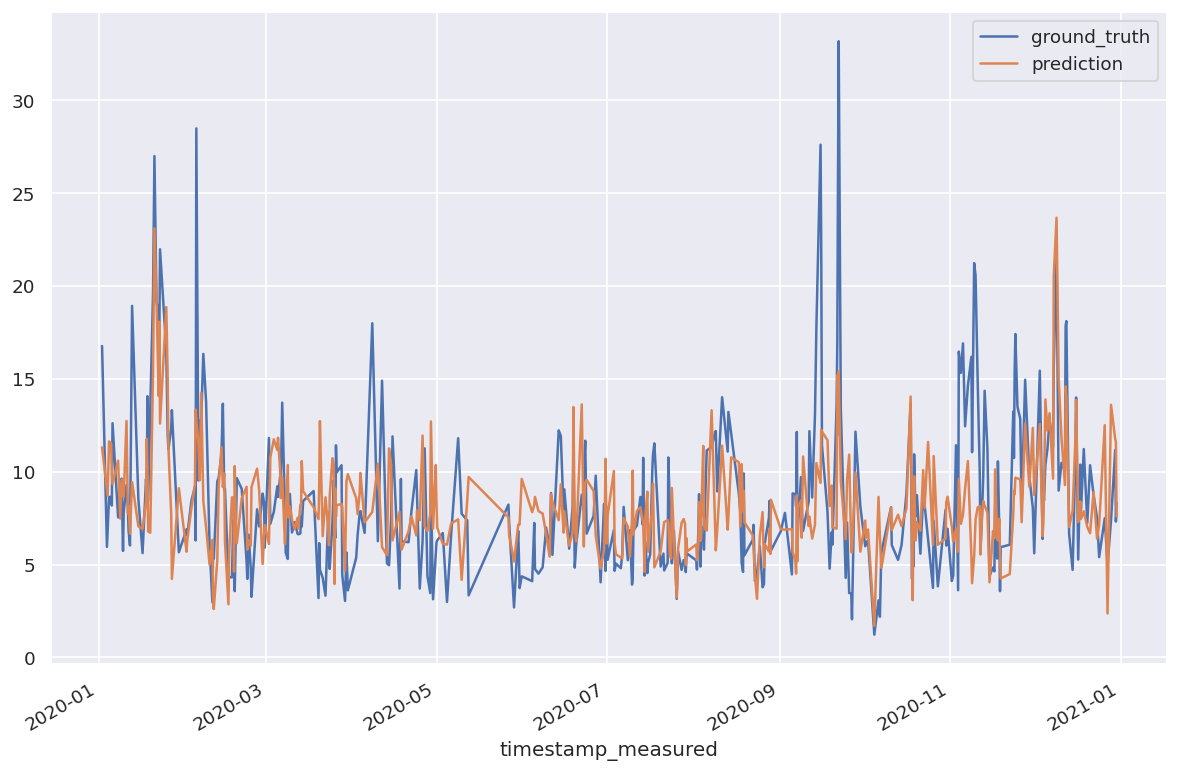

In [ ]:
df_result.plot(x="timestamp_measured", y=["ground_truth", "prediction"], figsize=(12,8))

Next we're plotting the feature importance.

In [ ]:
col_array

['pm25',
 'pm10',
 'fn',
 'c8h10',
 'c7h8',
 'c6h6',
 'no2',
 'no',
 'day_of_week',
 'temp',
 'visibility',
 'feels_like',
 'clouds_all']

Text(0.5, 1.0, 'Feature importance')

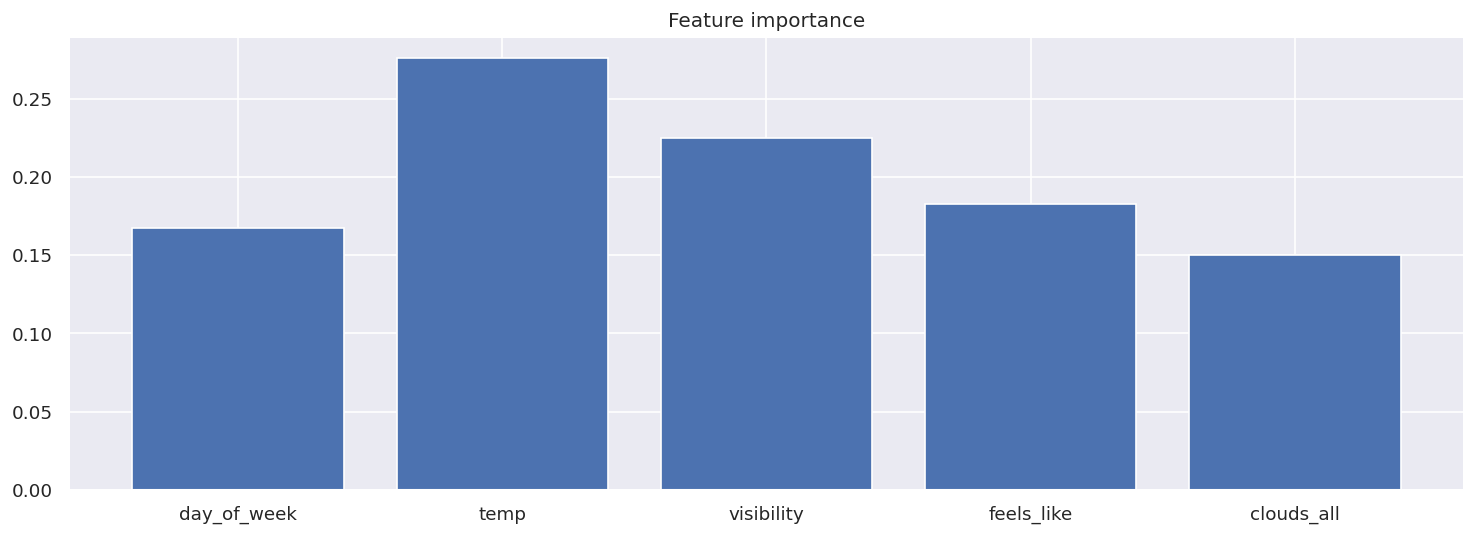

In [ ]:
col_array = []
score_array = []
for col,score in zip(train_X.iloc[:,1:].columns, model.feature_importances_):
  col_array.append(col)
  score_array.append(score)
  
plt.figure(figsize=(15,5))
plt.bar(range(len(col_array)), score_array)
plt.xticks(np.arange(0, len(col_array), step=1))
plt.xticks(np.arange(0, len(col_array), step=1), col_array)
plt.title('Feature importance')

## 👓 References
List all of the external links (even if they are already linked above), such as external datasets, papers, blog posts, code repositories and any other materials.

## ⏭️ Appendix
Add here any code, images or text that you still find relevant, but that was too long to include in the main report. This section is optional.


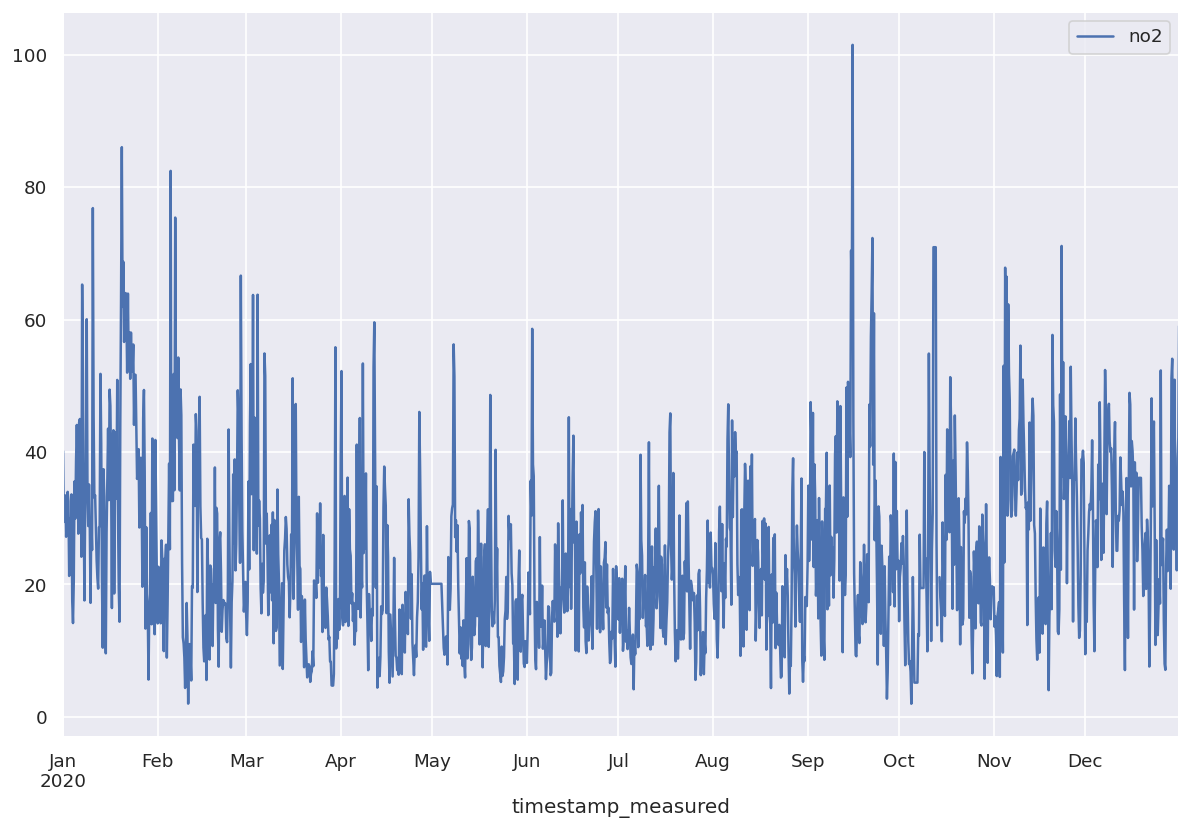

In [ ]:
df_sampled_6h.plot(x="timestamp_measured", y=["no2"], figsize=(12,8))

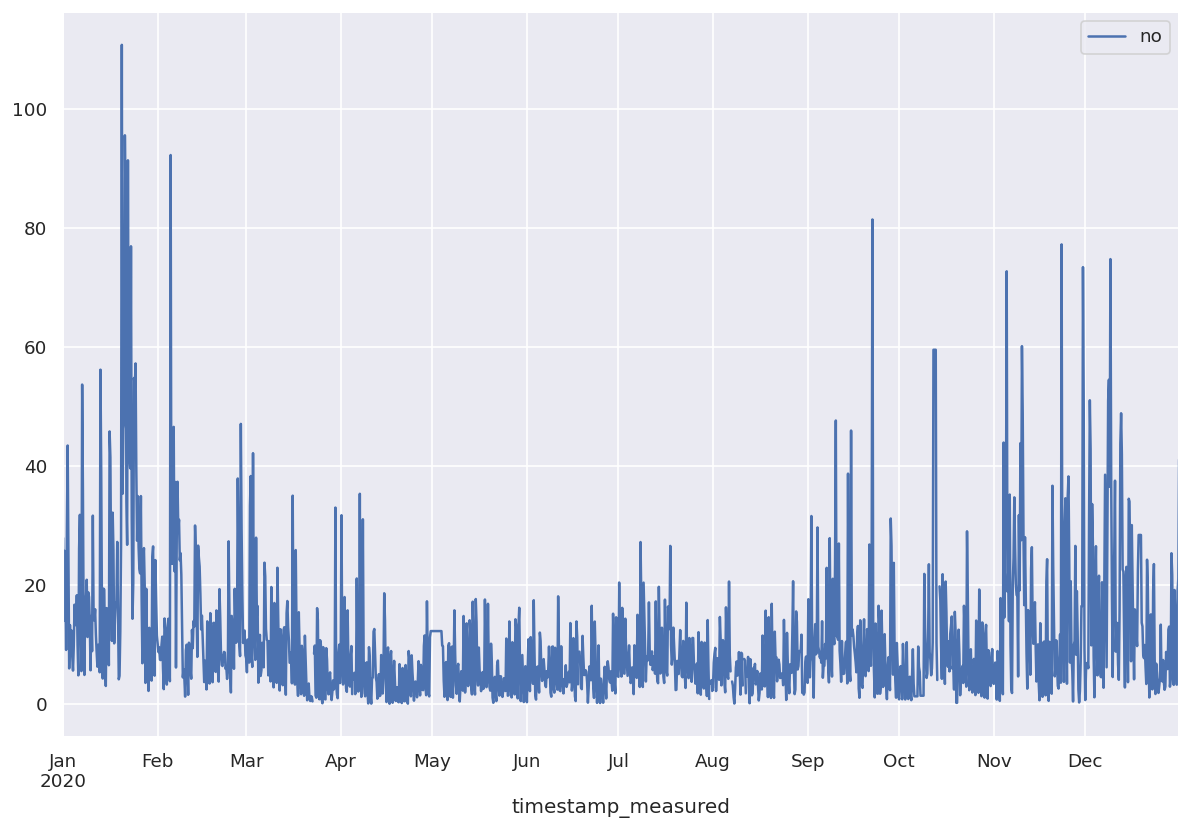

In [ ]:
df_sampled_6h.plot(x="timestamp_measured", y=["no"], figsize=(12,8))

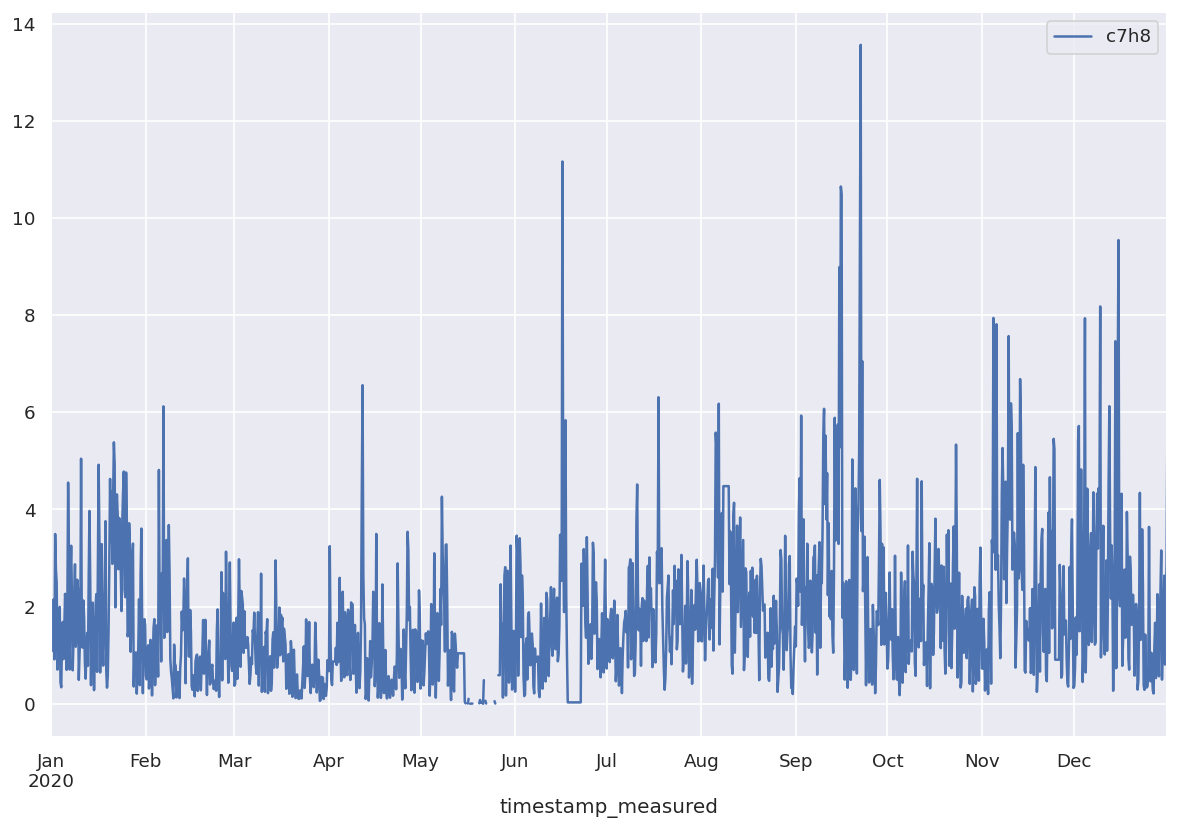

In [ ]:
df_sampled_6h.plot(x="timestamp_measured", y=["c7h8"], figsize=(12,8))

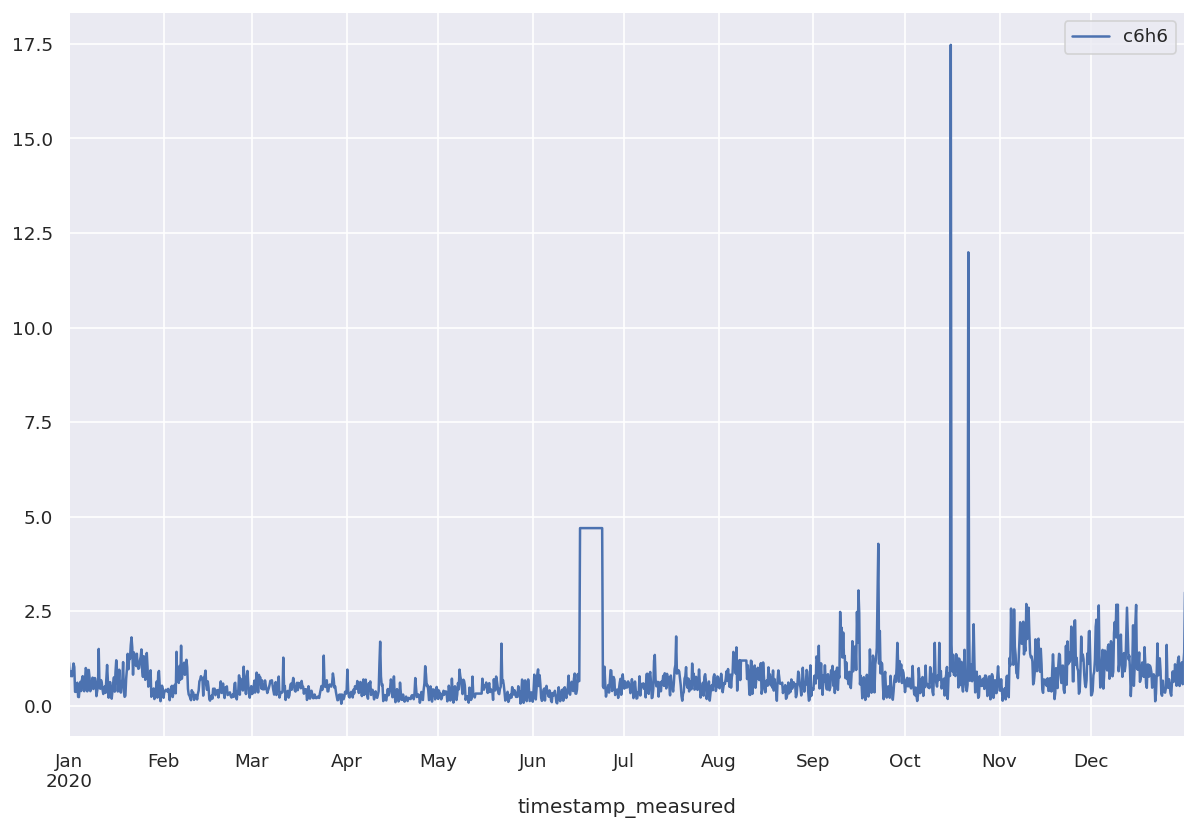

In [ ]:
df_sampled_6h.plot(x="timestamp_measured", y=["c6h6"], figsize=(12,8))

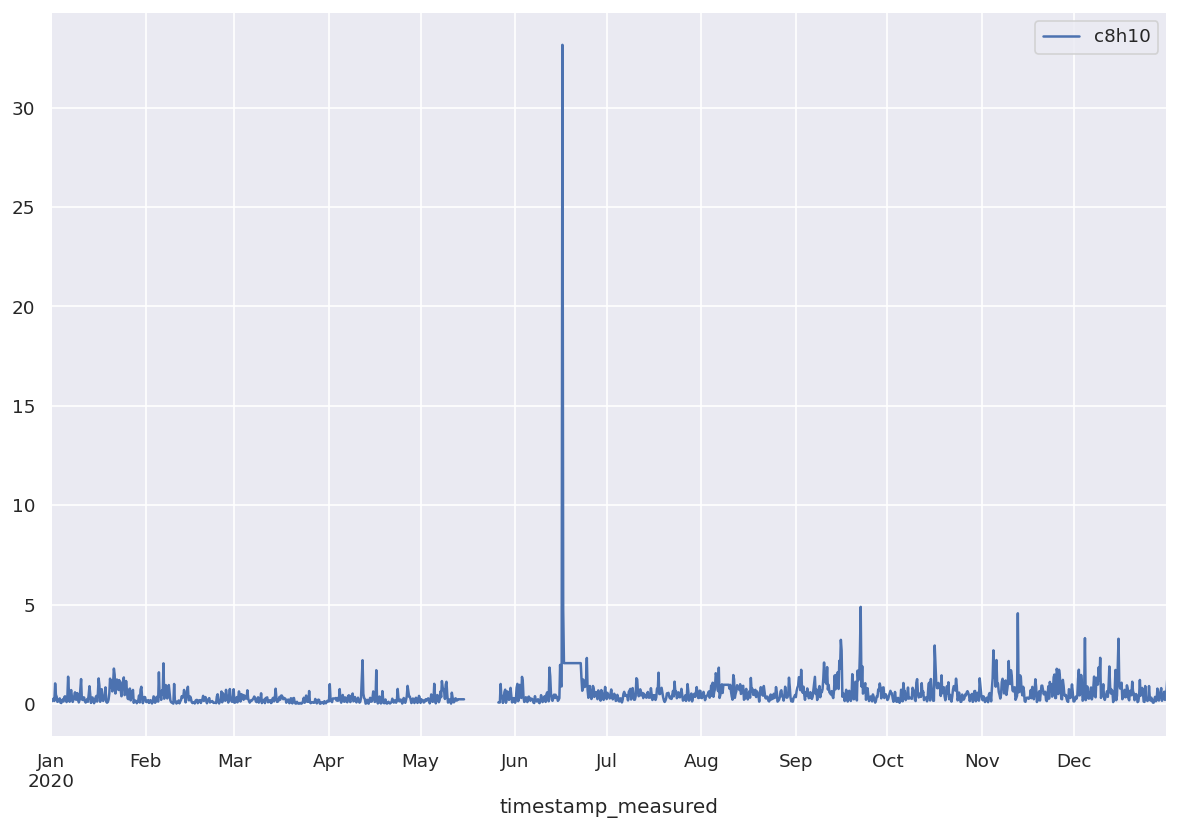

In [ ]:
df_sampled_6h.plot(x="timestamp_measured", y=["c8h10"], figsize=(12,8))

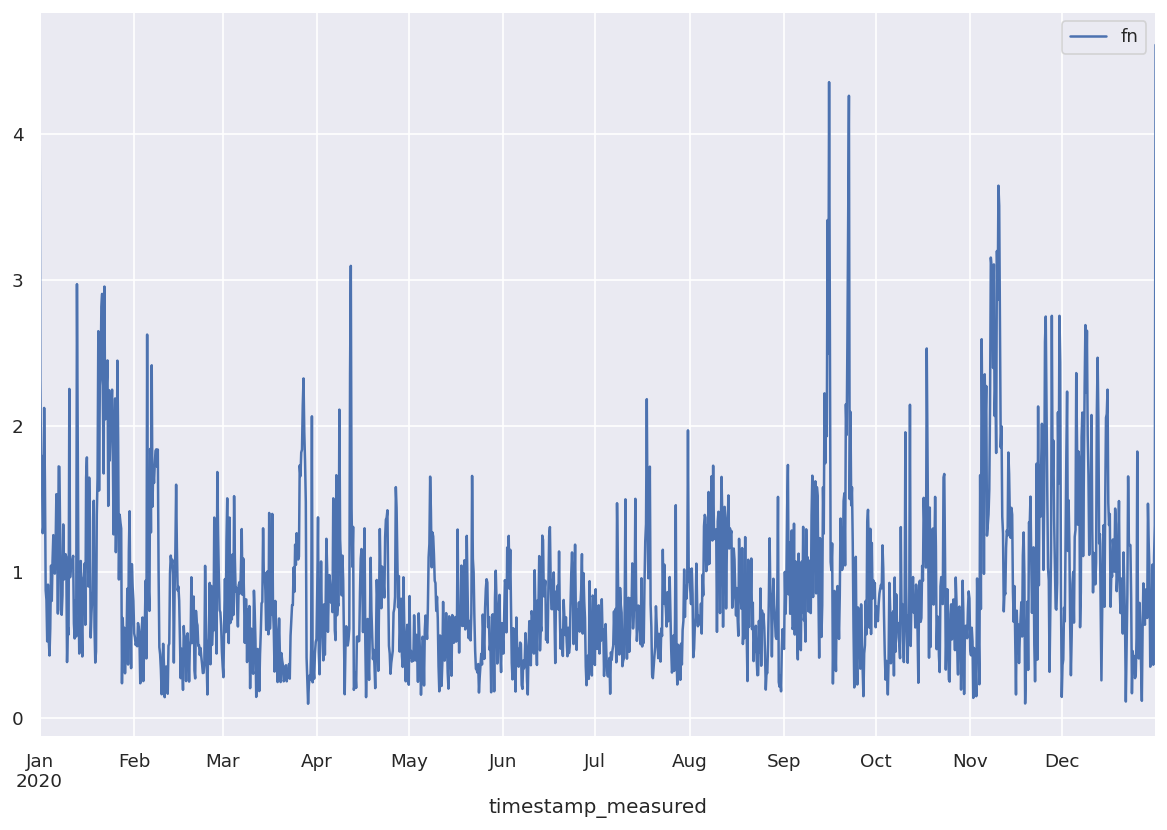

In [ ]:
df_sampled_6h.plot(x="timestamp_measured", y=["fn"], figsize=(12,8))

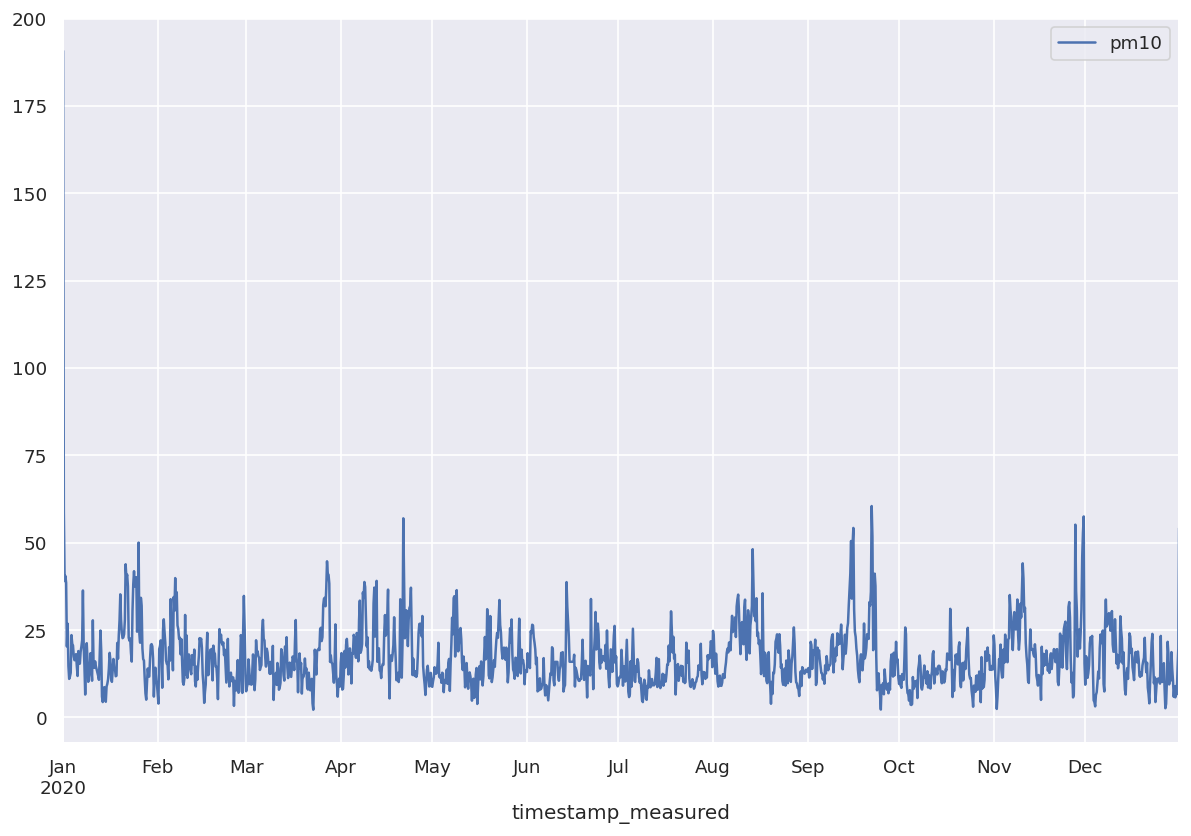

In [ ]:
df_sampled_6h.plot(x="timestamp_measured", y=["pm10"], figsize=(12,8))

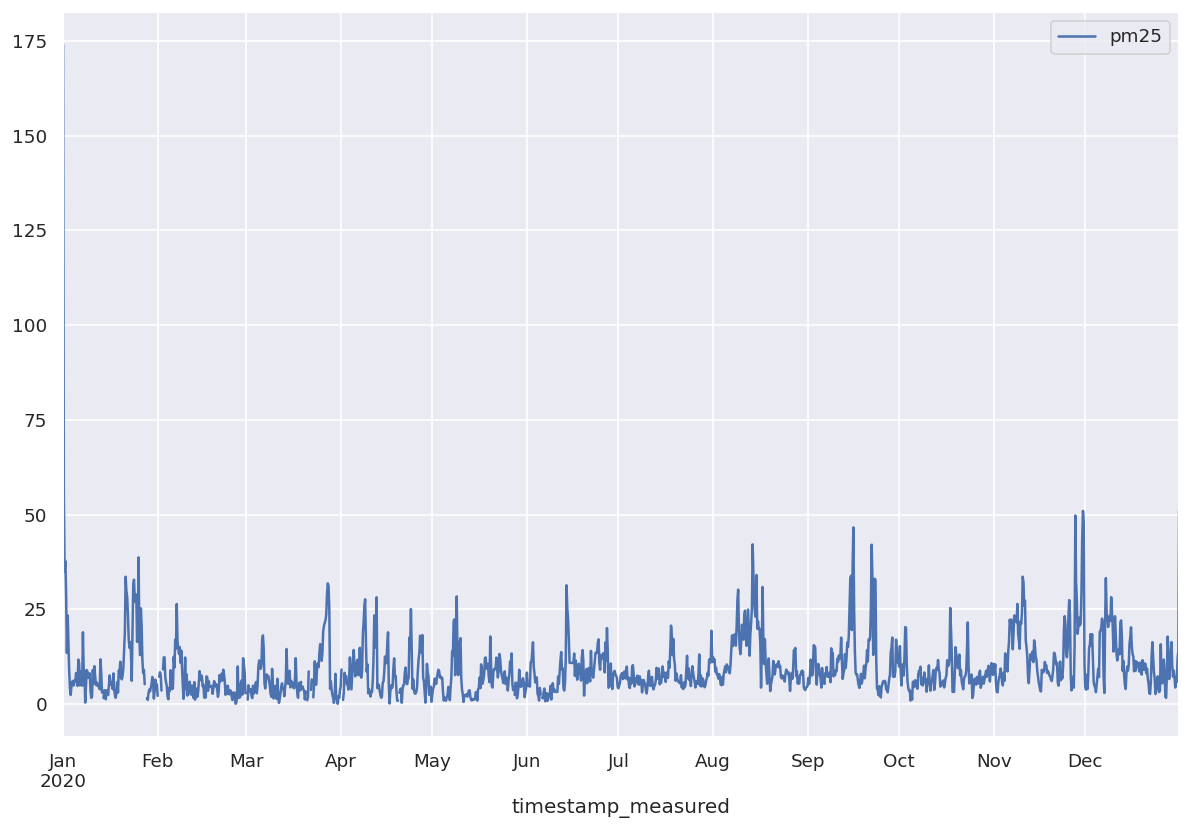

In [ ]:
df_sampled_6h.plot(x="timestamp_measured", y=["pm25"], figsize=(12,8))

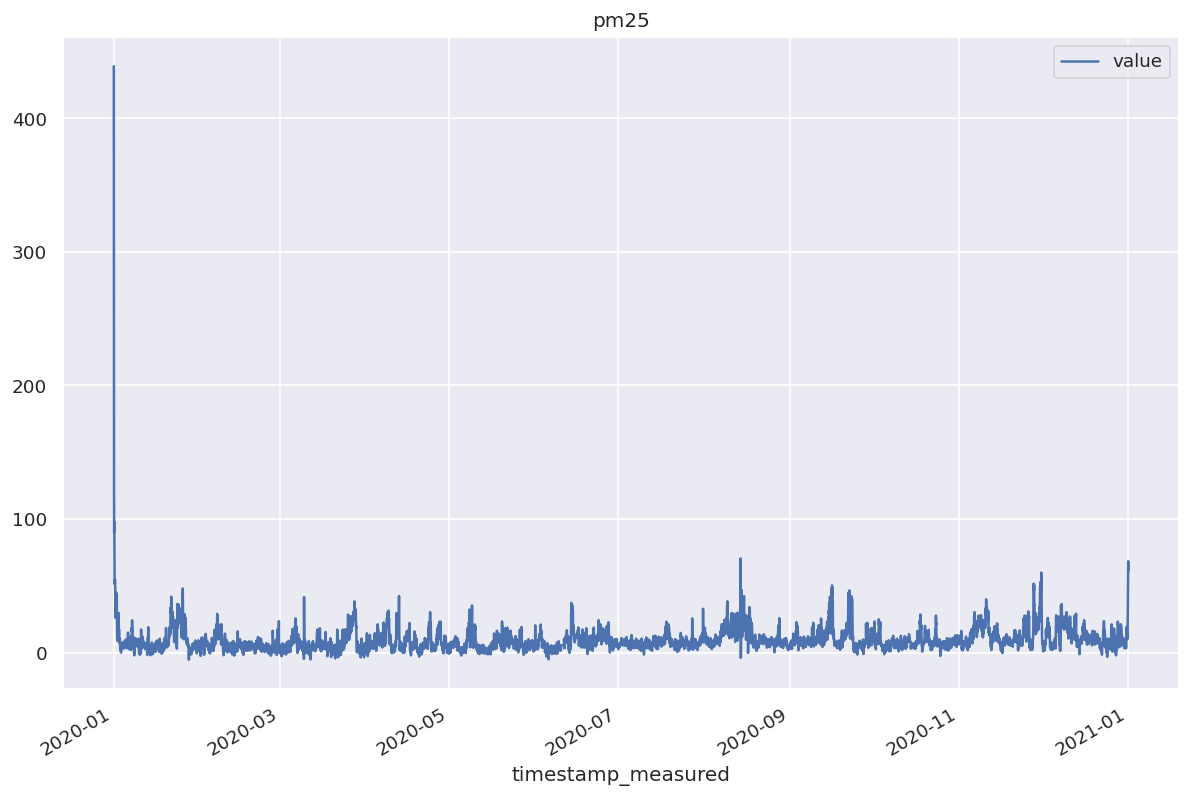

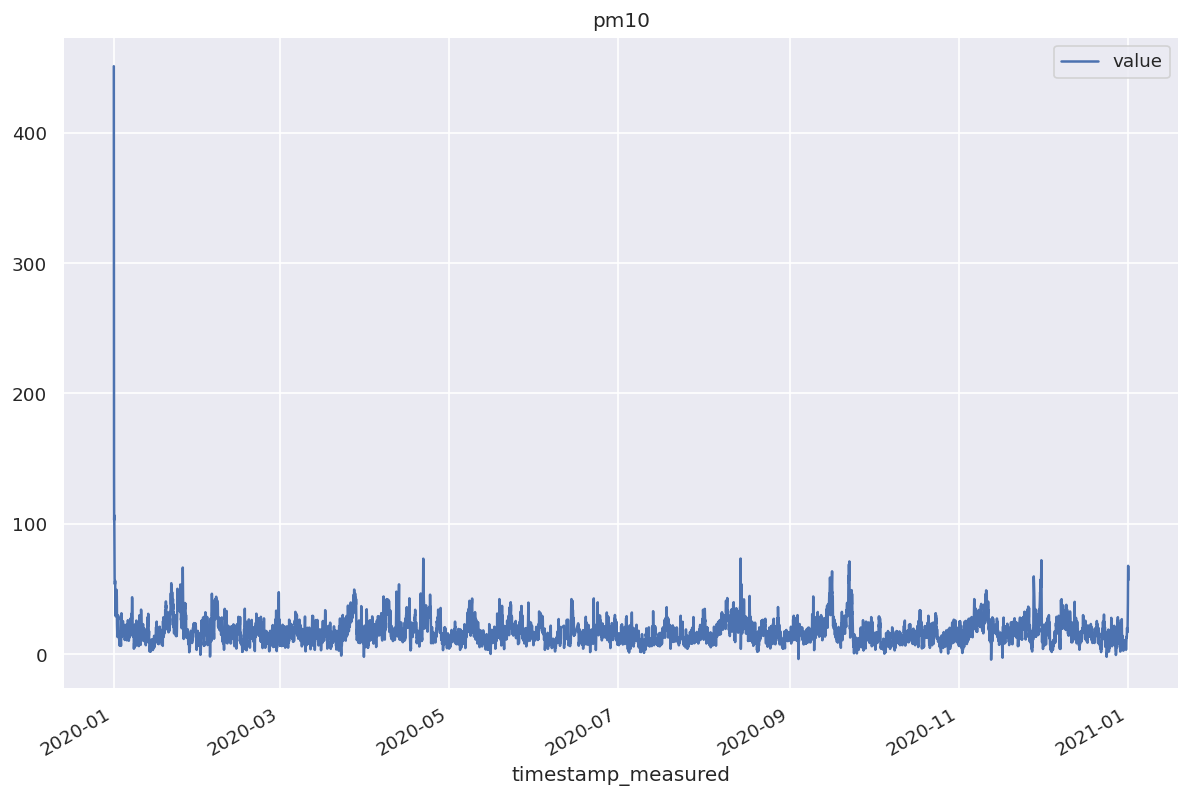

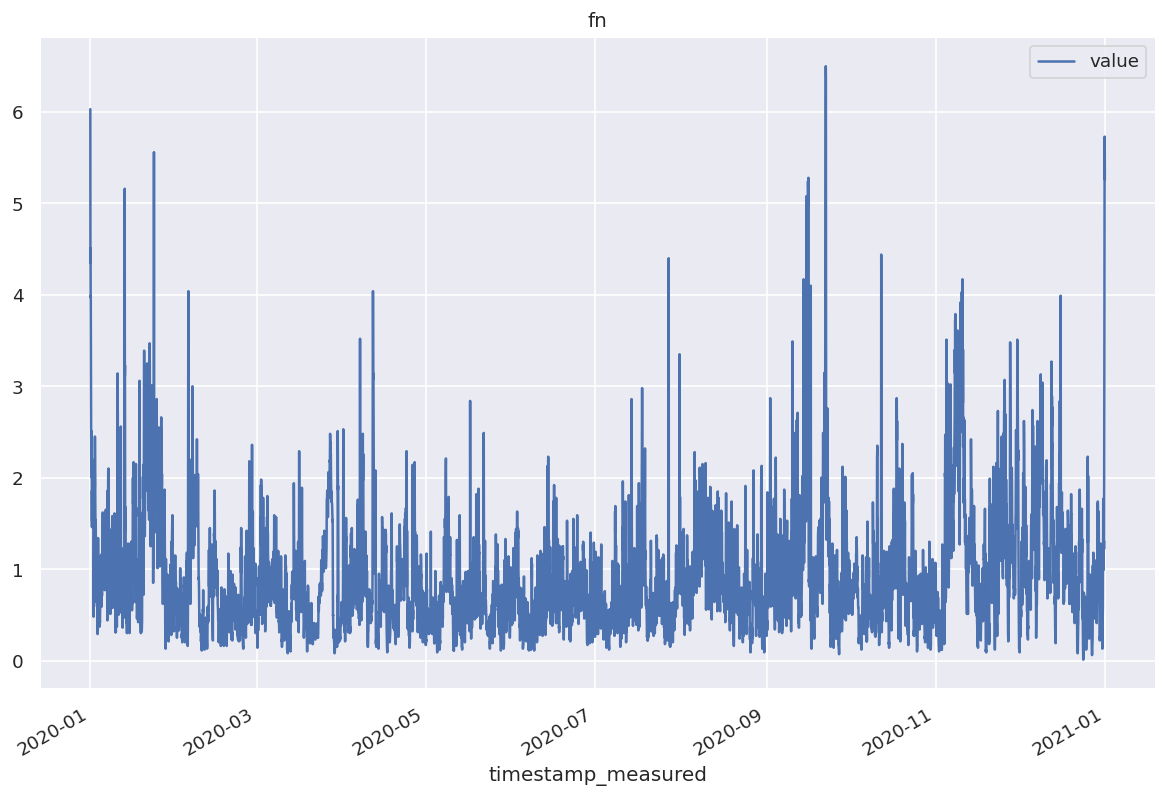

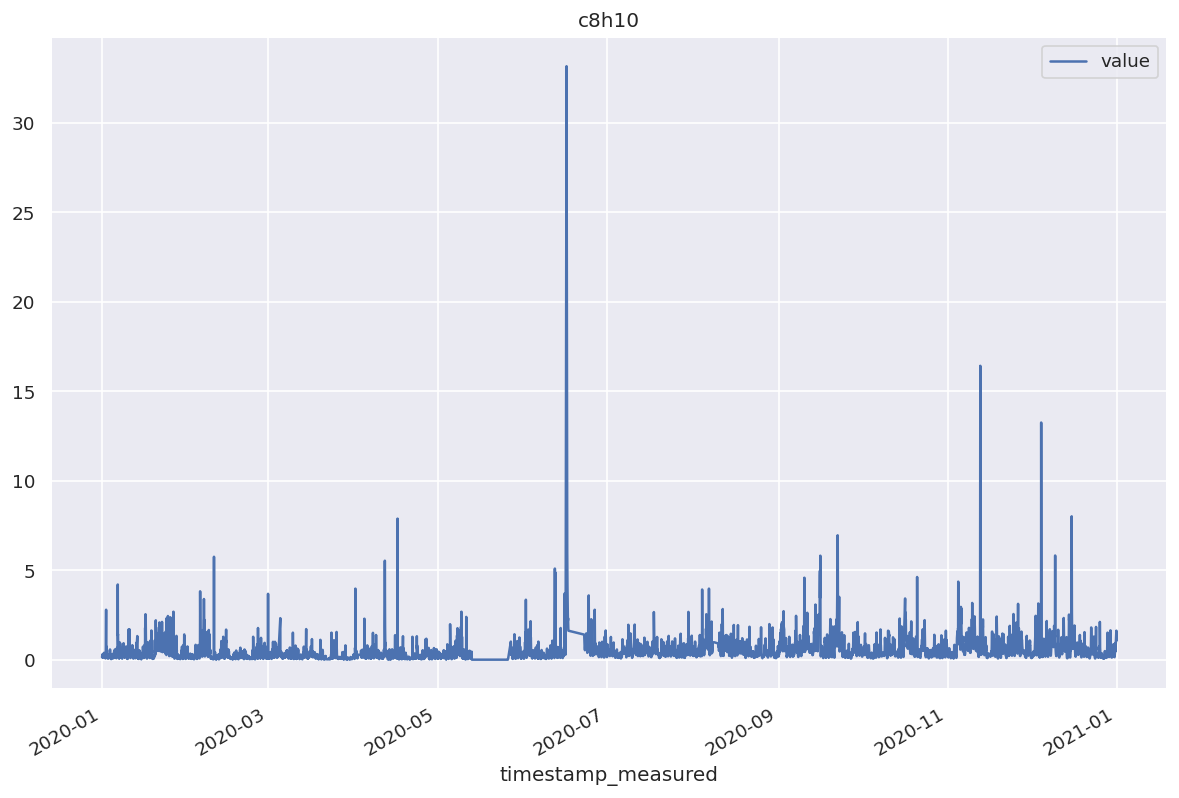

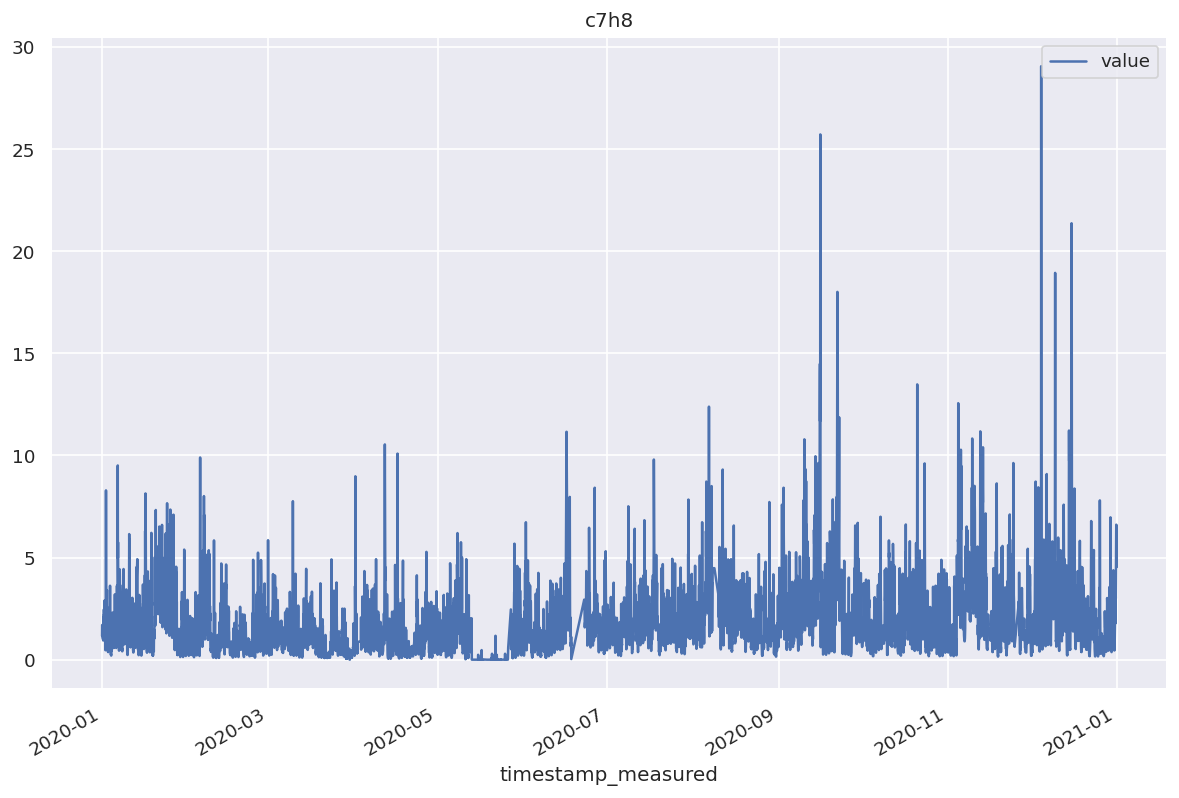

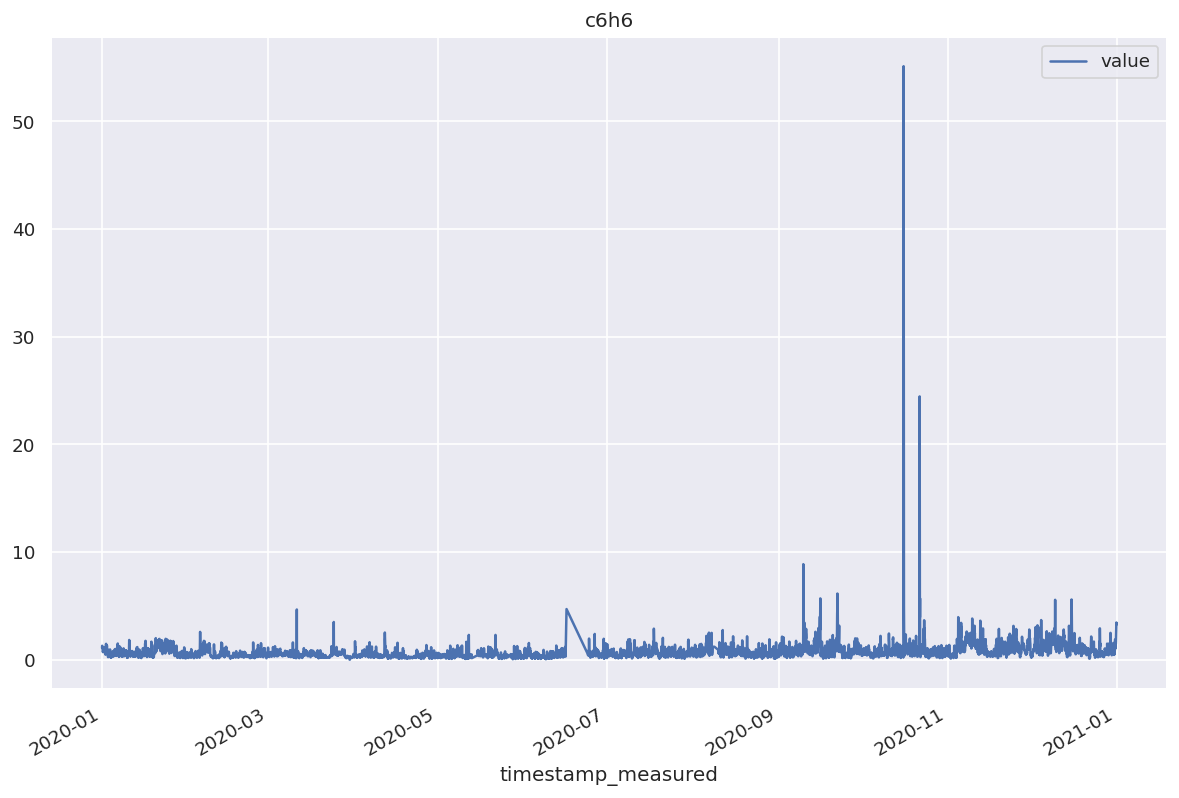

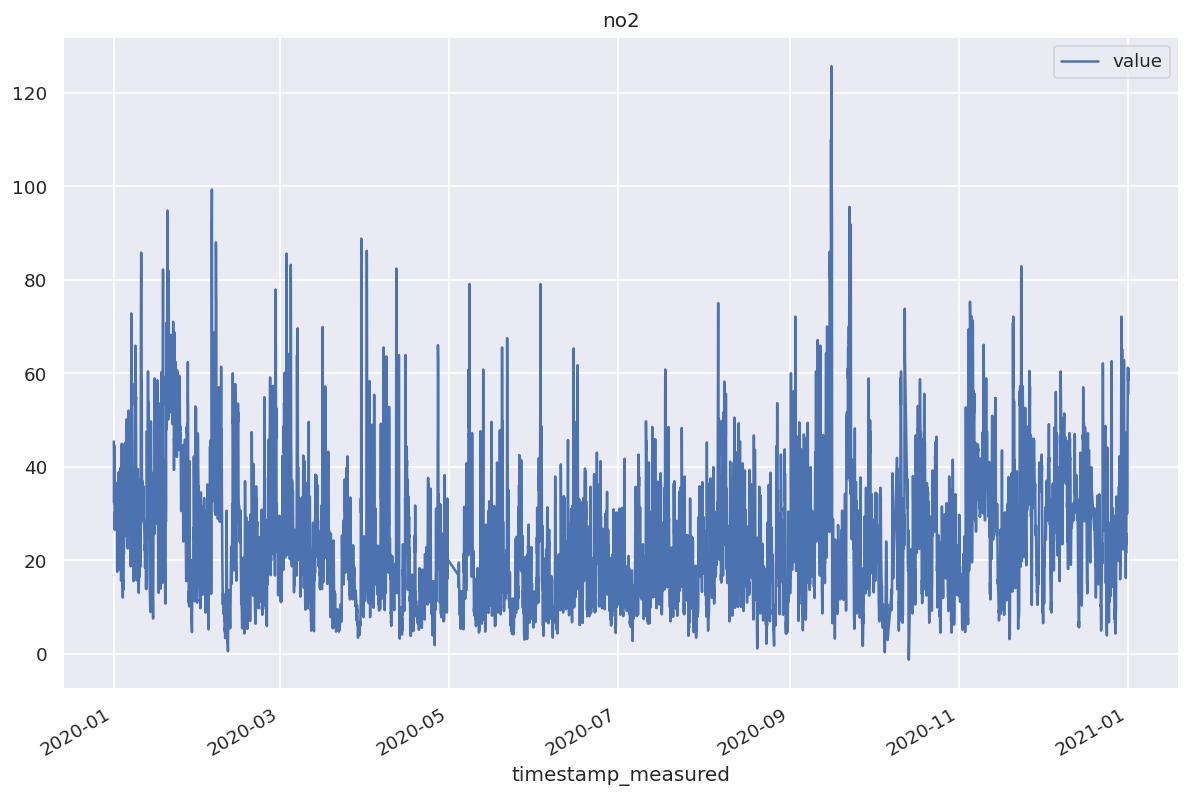

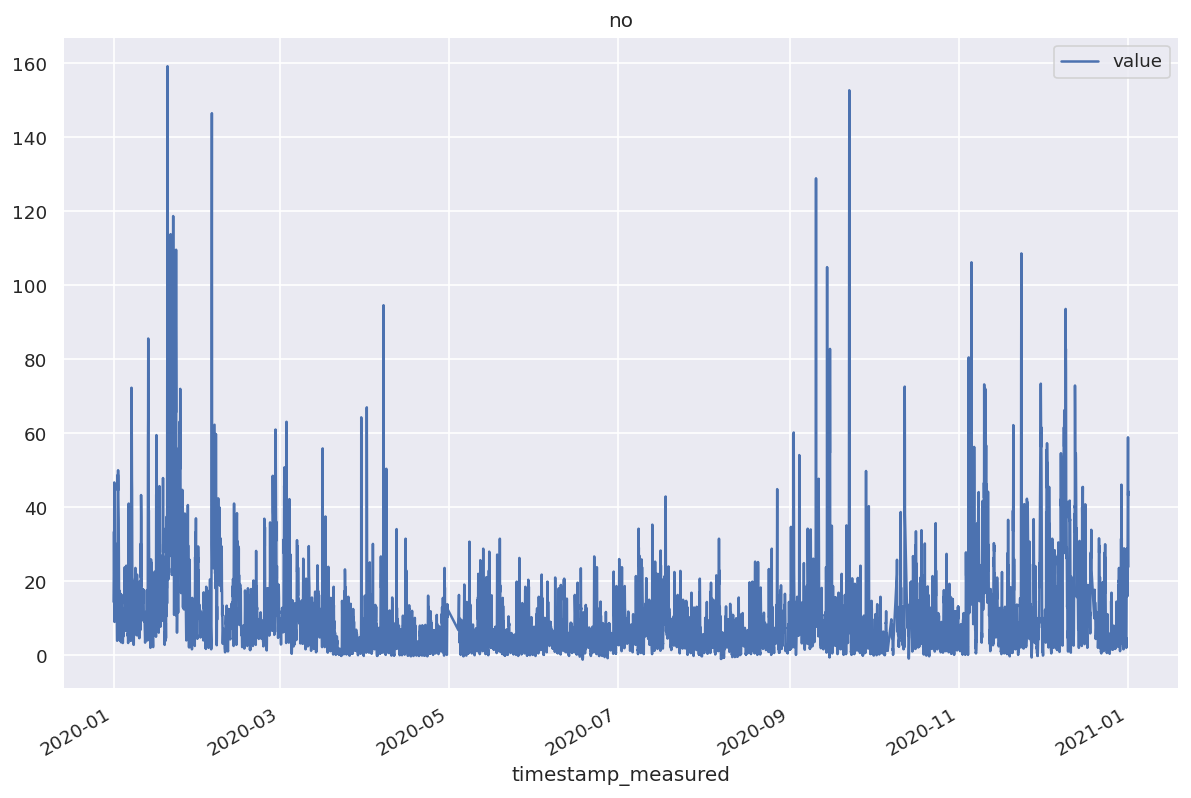

In [ ]:
for key, val in df_dict.items():
  df_dict[key].plot(x='timestamp_measured', y='value', kind='line', title=key, figsize=(12,8))